In [1]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt 
from dataloader import * 
from testCases import * 
import h5py
import math

%matplotlib inline 
plt.rcParams["figure.figsize"] = (7.0, 4.0) 
plt.rcParams["image.interpolation"] = 'nearest'
plt.rcParams["image.cmap"] = 'gray'

# All needed functions 

In [2]:
# sigmoid 
def sigmoid(x):
    s = 1/(1 + np.exp(-x))
    return s 

# ReLu
def relu(x): 
    s = np.maximum(0, x)
    return s


In [3]:
# initialize parameters 
def initialize_parameters(layer_dims):
    # to keep the output same 
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])/np.sqrt(layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters["W" + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layer_dims[l],1))
        
    return parameters

In [4]:
## forward propagation 
def forward_propagation(X, parameters):
    
    # retrieve parameters 
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # forward calculation 
    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3 
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2 ,Z3, A3, W3, b3)
    
    return A3, cache
    

In [5]:
# Backward propagation 
def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2 ,Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m)*np.dot(dZ3, A2.T)
    db3 = (1./m)*np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m)*np.dot(dZ2,A1.T)
    db2 = (1./m)*np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1>0))
    dW1 = (1./m)*np.dot(dZ1, X.T)
    db1 = (1./m)*np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [6]:
# prediction 
def predict(X, y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # forward propagation 
    a3, caches = forward_propagation(X, parameters)
    
    # convert probabilities to 0/1 predictions
    p[a3 > 0.5] = 1
    
    # accuracy 
    print("Accuracy:" + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [7]:
# compute cost 
def compute_cost(a3,Y):
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1 - a3), (1-Y))
    cost = (1./m)*np.nansum(logprobs)
    
    return cost 

In [8]:
# loading dataset 
def load_dataset(): 
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    
    test_dateset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dateset["test_set_x"][:])
    test_set_y_orig = np.array(test_dateset["test_set_y"][:])
    
    classes = np.array(test_dateset["list_classes"][:])
    
    train_set_y = train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/ 255
    test_set_x = test_set_x_orig/255
    
    return train_set_x, train_set_y, test_set_x, test_set_y, classes

In [9]:
# predict_dec 
def predict_dec(parameters, X):
    
    a3, cache = forward_propagation(X, parameters)
    prediction = (a3 > 0.5)
    return prediction

## cost and back prop with regularization

In [10]:
# compute cost with regularization 
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    
    # L2 regularization term 
    regularization_cost = (1./m)*(lambd/2)*(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    # Total cost 
    total_cost = cross_entropy_cost + regularization_cost
    
    return total_cost

# backward_propagation_with_regularization 
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    """
    With regularization, each calculation of dw will have and added term of regularization
    with it 
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m)*np.dot(dZ3, A2.T) + (lambd/m)*W3
    db3 = (1./m)*np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3) 
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m)*np.dot(dZ2, A1.T) + (lambd/m)*W2
    db2 = (1./m)*np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1,np.int64(A1 > 0))
    dW1 = (1./m)*np.dot(dZ1, X.T) + (lambd/m)*W1
    db1 = (1./m)*np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
    
    

## forward and backward propagation with dropout 

In [11]:
# forward propagation with dropout 
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    
    # fixing randomenss for similar result 
    np.random.seed(1)
    
    # retrive parameters 
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # forward propagation 
    Z1 = np.dot(W1, X) + b1 
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = A1*D1 # set some values to zero
    A1 = A1/keep_prob # scale to maintain the effect 
    
    Z2 = np.dot(W2, A1) + b2 
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = A2*D2
    A2 = A2/keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

# backwars propagation with dropout
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1./m)*np.dot(dZ3, A2.T)
    db3 = (1./m)*np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2*D2
    dA2 = dA2/keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1./m)*np.dot(dZ2, A1.T)
    db2 = (1./m)*np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1*D1
    dA1 = dA1/keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1./m)*np.dot(dZ1, X.T)
    db1 = (1./m)*np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
    
    

# various optimization methods 

* Gradient descent 
* mini-batch gradient descent 
* stochastic gradient descent 
* Momentum
* Adam

In [12]:
# Gradient descent 
def update_parameters_with_gd(parameters, grads, learning_rate):
    
    # L number of layers of neural network 
    L = len(parameters)//2
    
    # update rule 
    for l in range(L): 
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l + 1)]
        
    return parameters

# Batch/ mini-batch/ Stochstic gradient descent 

* We can control type of gradient descent with size of the batch 
    - batch gradient descen = size m 
    - stochastic gradient descent = size 1
    - mini batch gradient descent = size 2^x

```python
# stochastic gradient descent
X = data_input 
Y = labels 
parameters = initialize_parameters(layer_dims)
for i in range(num_iterations): 
    for j in range(m):
        # forward porpagation 
        a3, caches = forward_propagation(X[:,j], parameters)
        
        # compute cost 
        cost += compute_cost(a, Y[:,j])
        
        # backward propagation 
        grads = backward_propagation(a, caches, parameters)
        
        #update parameters
        parameters = update_parameters(parameters, grads)
```



In [13]:
# creating mini batches with random shuffling 
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # shuffle all examples 
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    # Partition into mini batches now,
    # not always total examples will be divisible by mini_batch_size so we 
    # need to handle end case.
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    # End case 
    if m % mini_batch_size !=0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
    

# Momentum 

In [14]:
# initialize a dictionary to keep track of the velocity for 'dW' and 'db'
def initialize_velocity(parameters):
    
    L = len(parameters)//2
    v = {}
    
    # initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        
    return v

# parameter update with momentum 
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    
    L = len(parameters)//2
    
    # update 
    # first, calculate the velocity term 
    # then, update the parameters using that velocity term instead of using gradient terms 
    for l in range(L):
        # calculate the velocity term
        v["dW"+str(l+1)] = beta*v["dW"+str(l+1)] + (1-beta)*grads["dW"+str(l+1)]
        v["db"+str(l+1)] = beta*v["db"+str(l+1)] + (1-beta)*grads["db"+str(l+1)]
        
        # update parameters with velocity 
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learning_rate*v["dW"+str(l+1)]
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learning_rate*v["db"+str(l+1)]
    
    return parameters, v
        
        
        
        

# Adaptive momentum (Adam)

* It combines RMSprop and momentum
* Unlike in momentum, this does bias correction in both RMS prop and momentum values
* one of the best method for descent 

In [15]:
# initialize parameters for Adam 
def initialize_adam(parameters): 
    
    L = len(parameters)//2
    v = {} # velocity dict
    s = {} # RMS prop dict
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        
    return v, s

# Update with Adam 
def update_parameters_with_adam(parameters, grads, v, s, t, learnin_rate=0.01,
                               beta1=0.9, beta2=0.999, epsilon=1e-8):
    
    L = len(parameters)//2
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        
        # calculate velocity terms
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads["db" + str(l+1)]
        
        # Bias correction for velocity 
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1- beta1**t)
        
        # Calculate second moment, squared gradient
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*(np.multiply(grads["dW" + str(l+1)], grads["dW" + str(l+1)]))
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*(np.multiply(grads["db" + str(l+1)], grads["db" + str(l+1)]))
        
        # bias correction for squared gradient
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1- beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1- beta2**t)
        
        # Adam update equation 
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - learnin_rate*(v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)]) +epsilon))
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - learnin_rate*(v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)]) +epsilon))
    
    return parameters, v, s

## Model implementation


In [16]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
   

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. 
        # We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # unpack X and Y componenets
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            # we add this to all previous cost so as to keep track of total cost.
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                # Adam counter
                # we track counter with faith that with increase in number less 
                # bias correction will be needed.
                t = t + 1 
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        # average the total cost
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

## Loading dataset 

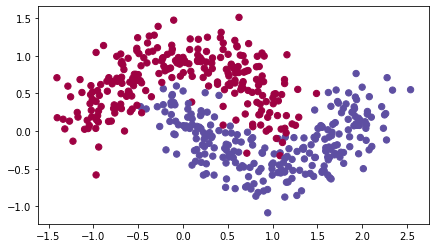

In [17]:
# loading 2D dataset 
# train_X, train_Y, test_X, test_Y = load_2D_dataset()

# loading planar dataset 
# train_X, train_Y = load_planar_dataset(1)

# moon dataset
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=500, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=np.squeeze(train_Y), s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

train_X, train_Y = load_dataset()


# Model with different optimizations 

* we will run different models of same depth and layer dimensions with different optimizationa nd record the results 

## 1. mini-batch gradient descent 

Cost after epoch 0: 0.011158
Cost after epoch 1000: 0.010747
Cost after epoch 2000: 0.010100
Cost after epoch 3000: 0.009065
Cost after epoch 4000: 0.007760
Cost after epoch 5000: 0.006205
Cost after epoch 6000: 0.005229
Cost after epoch 7000: 0.004805
Cost after epoch 8000: 0.004558
Cost after epoch 9000: 0.004465


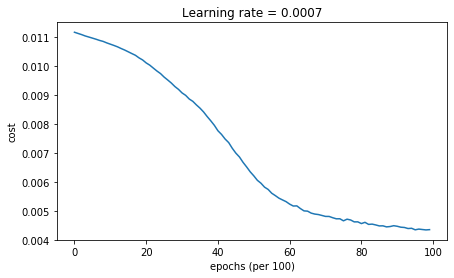

Accuracy:0.896


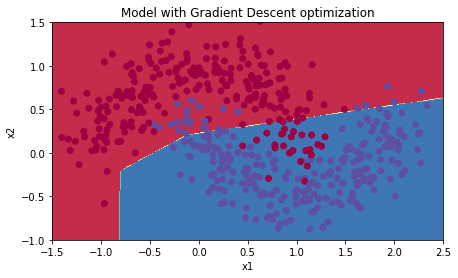

In [18]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Point: 
* A simplegradien discent shows that the model has bias problem, we can check if we need to increase the dimensions of layers.
* After trying a number of layer dimensions, we see that after a point the improvements stops, no matter how much dimenstion you keep adding in the network.
* But later we will see that with even original layer dimension, we can do much better by adopting different optimization methods. 
* with 6 fold increase in layer dimension, we could only improve 4 % in accuracy

Cost after epoch 0: 0.011195
Cost after epoch 1000: 0.004531
Cost after epoch 2000: 0.004227
Cost after epoch 3000: 0.004093
Cost after epoch 4000: 0.003944
Cost after epoch 5000: 0.003885
Cost after epoch 6000: 0.003728
Cost after epoch 7000: 0.003595
Cost after epoch 8000: 0.003435
Cost after epoch 9000: 0.003332


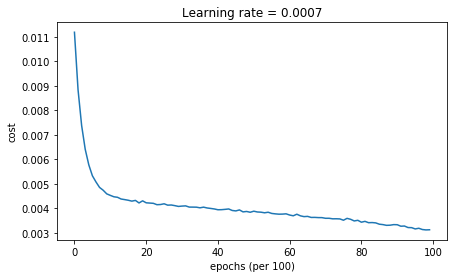

Accuracy:0.93


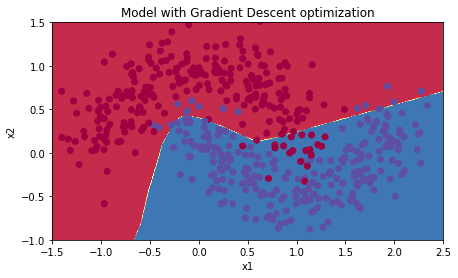

In [19]:
# Running GD with increase dimensions

layers_dims = [train_X.shape[0], 30, 20, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## 2. mini batch gradient descent with momentum

Cost after epoch 0: 0.011158
Cost after epoch 1000: 0.010748
Cost after epoch 2000: 0.010102
Cost after epoch 3000: 0.009068
Cost after epoch 4000: 0.007766
Cost after epoch 5000: 0.006212
Cost after epoch 6000: 0.005232
Cost after epoch 7000: 0.004806
Cost after epoch 8000: 0.004559
Cost after epoch 9000: 0.004466


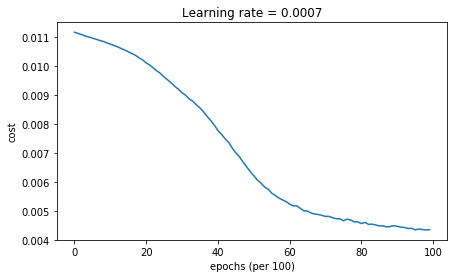

Accuracy:0.896


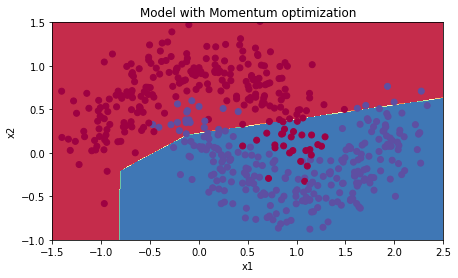

In [20]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.010738
Cost after epoch 1000: 0.006523
Cost after epoch 2000: 0.005139
Cost after epoch 3000: 0.004728
Cost after epoch 4000: 0.004450
Cost after epoch 5000: 0.004273
Cost after epoch 6000: 0.004068
Cost after epoch 7000: 0.003936
Cost after epoch 8000: 0.003808
Cost after epoch 9000: 0.003737


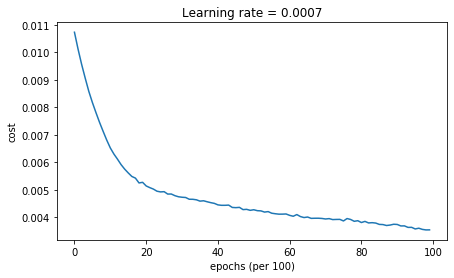

Accuracy:0.906


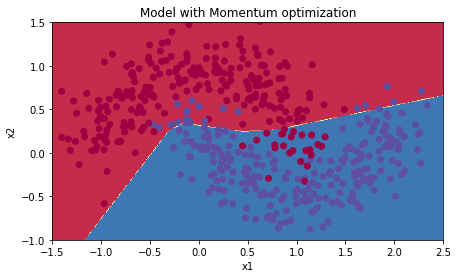

In [21]:
# Increasing the dimensions of layer

layers_dims = [train_X.shape[0], 10, 5, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Mini batch with Adam 

Cost after epoch 0: 0.011149
Cost after epoch 1000: 0.001233
Cost after epoch 2000: 0.001028
Cost after epoch 3000: 0.001002
Cost after epoch 4000: 0.000958
Cost after epoch 5000: 0.000966
Cost after epoch 6000: 0.000924
Cost after epoch 7000: 0.000906
Cost after epoch 8000: 0.000886
Cost after epoch 9000: 0.000893


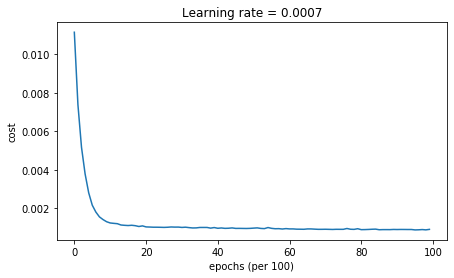

Accuracy:0.984


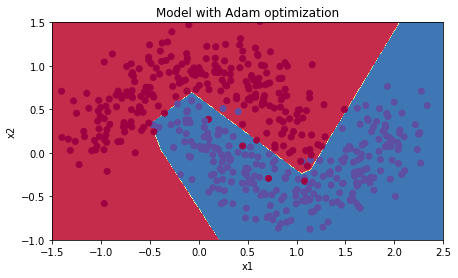

In [22]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

# conclusions

* simple gradient descent stops improving after certain limit, even after multifold increase in layer dimensions.
* Momentum did not should much impact, because of simplistic dataset 
* Adam clearly outperfomrs all with smallest layer dimensions, which shows that choosing a better descent approach can reduce the requirement of numb of layers and layer dimensions